In [22]:
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import PIL.Image
import json

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Cargar las imagenes y las labels

In [ ]:
# Rutas para guardar las imágenes y etiquetas
image_paths = []
labels = []

# Directorio que contiene los archivos CSV
csv_directory = "./labels"
# Procesar todos los archivos CSV en el directorio
for filename in os.listdir(csv_directory):
    if filename.endswith(".csv"):
        with open(os.path.join(csv_directory, filename), "r") as file:
            reader = csv.reader(file)
            next(reader)  # Saltar la cabecer
            for row in reader:
                image_paths.append(row[0])
                etiquetas = list(map(int, row[1].strip("[]").split(", ")))
                labels.append([etiquetas[0], etiquetas[3], etiquetas[4]])  # Tomar etiquetas 1, 4 y 5

labels = np.array(labels)

print("Imágenes:", image_paths[:3])  
print("Etiquetas:", labels[:3])      

Imágenes: ['Dataset P2/Celebrity Faces Dataset/Brad Pitt/001_c04300ef.jpg', 'Dataset P2/Celebrity Faces Dataset/Brad Pitt/002_cc1b9701.jpg', 'Dataset P2/Celebrity Faces Dataset/Brad Pitt/003_7a6b2156.jpg']
Etiquetas: [[0 0 0]
 [0 0 0]
 [1 0 0]]


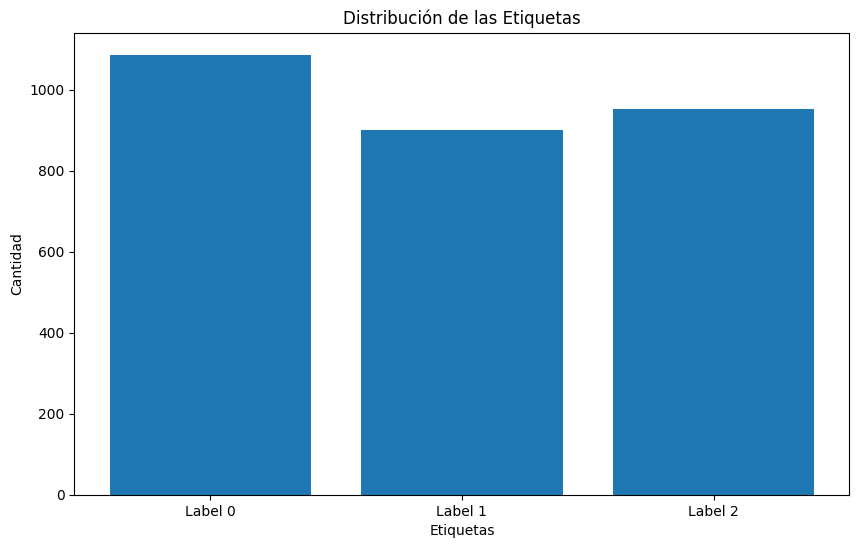

In [24]:
# Contar la cantidad de cada etiqueta
label_counts = np.sum(labels, axis=0)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(label_counts)), label_counts, tick_label=[f'Label {i}' for i in range(len(label_counts))])
plt.xlabel('Etiquetas')
plt.ylabel('Cantidad')
plt.title('Distribución de las Etiquetas')
plt.show()

## Preprocesado de los datos y división del dataset

In [25]:
# Dimensiones a las que redimensionar las imágenes
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Cargar imágenes y etiquetas
image_data = []
for image_path in image_paths:
    # Cargar imagen desde archivo
    img = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    # Convertir la imagen a un array numpy
    img_array = tf.keras.utils.img_to_array(img)
    # Normalizar los valores de los píxeles (0-255 a 0-1)
    img_array = img_array / 255.0
    image_data.append(img_array)

# Convertir a tensores para entrenar
image_data = np.array(image_data)
labels = np.array(labels)

# Verificar formas
print("Forma de los datos de imágenes:", image_data.shape)
print("Forma de las etiquetas:", labels.shape)

Forma de los datos de imágenes: (1800, 128, 128, 3)
Forma de las etiquetas: (1800, 3)


In [ ]:
# Dividir datos en entrenamiento (70%), validación (15%) y prueba (15%)
X_train, X_temp, y_train, y_temp = train_test_split(image_data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de validación: {X_val.shape}")
print(f"Datos de prueba: {X_test.shape}")

np.savez('test_data.npz', X_test=X_test, y_test=y_test)

Datos de entrenamiento: (1260, 128, 128, 3)
Datos de validación: (270, 128, 128, 3)
Datos de prueba: (270, 128, 128, 3)


## Definición de los generadores de datos

In [27]:
# Inicializar el generador de datos para entrenamiento con data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,  # Rotar las imágenes aleatoriamente
    width_shift_range=0.2,  # Desplazamiento horizontal
    height_shift_range=0.2,  # Desplazamiento vertical
    shear_range=0.2,  # Cizallamiento
    zoom_range=0.2,  # Zoom aleatorio
    horizontal_flip=True,  # Voltear imágenes horizontalmente
    fill_mode='nearest'  # Método de relleno para píxeles faltantes
)

# Generador de datos para la validación (sin data augmentation)
val_datagen = ImageDataGenerator()

# Ajustar las imágenes a los generadores
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

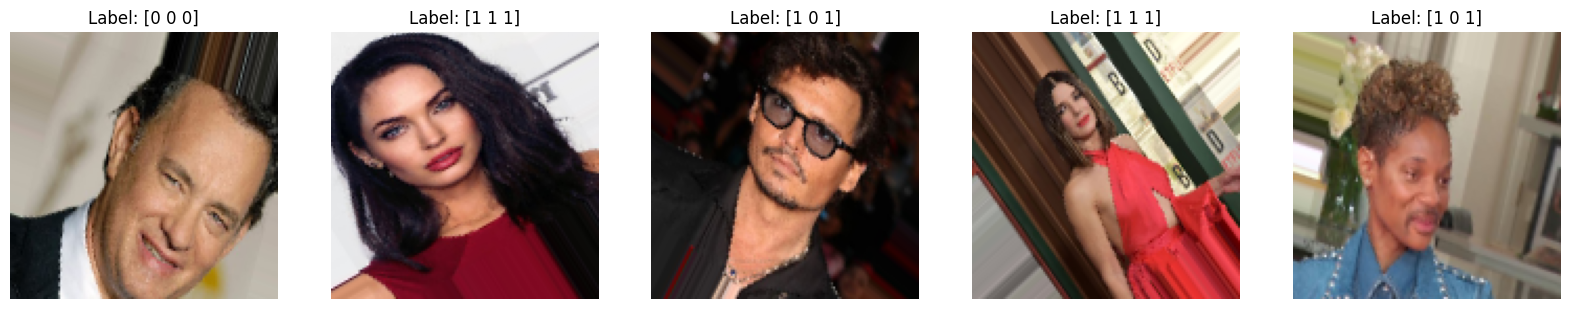

In [28]:
# Obtener un lote de imágenes y etiquetas del generador
images, labels = next(train_generator)

# Mostrar las primeras 5 imágenes del lote
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.show()

In [29]:
print("Total samples in train_generator:", len(X_train))

Total samples in train_generator: 1260


# Creación del modelo

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import json
import os
import uuid

class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_dir):
        super().__init__()
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def on_train_end(self, logs=None):
        # Generate a unique identifier for the trial
        unique_id = str(uuid.uuid4())
        history_path = os.path.join(self.save_dir, f'trial_{unique_id}_history.json')

        # Save the model's training history
        with open(history_path, 'w') as f:
            json.dump(self.model.history.history, f)


class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

def build_model(hp):
    model = Sequential()

    # First Conv2D layer with optional regularization and Batch Normalization
    regularizer_1_choice = hp.Choice('regularizer_1', values=['None', 'l1', 'l2'])
    if regularizer_1_choice == 'l1':
        regularizer_1 = l1(1e-4)
    elif regularizer_1_choice == 'l2':
        regularizer_1 = l2(1e-4)
    else:
        regularizer_1 = None

    model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
        activation='relu',
        kernel_regularizer=regularizer_1,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    ))
    if hp.Boolean('batch_norm_1'):
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Conv2D layer
    regularizer_2_choice = hp.Choice('regularizer_2', values=['None', 'l1', 'l2'])
    if regularizer_2_choice == 'l1':
        regularizer_2 = l1(1e-4)
    elif regularizer_2_choice == 'l2':
        regularizer_2 = l2(1e-4)
    else:
        regularizer_2 = None

    model.add(Conv2D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        activation='relu',
        kernel_regularizer=regularizer_2
    ))
    if hp.Boolean('batch_norm_2'):
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Conv2D layer
    regularizer_3_choice = hp.Choice('regularizer_3', values=['None', 'l1', 'l2'])
    if regularizer_3_choice == 'l1':
        regularizer_3 = l1(1e-4)
    elif regularizer_3_choice == 'l2':
        regularizer_3 = l2(1e-4)
    else:
        regularizer_3 = None

    model.add(Conv2D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_3', values=[3, 5]),
        activation='relu',
        kernel_regularizer=regularizer_3
    ))
    if hp.Boolean('batch_norm_3'):
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(Flatten())

    # First Dense layer
    regularizer_dense_1_choice = hp.Choice('regularizer_dense_1', values=['None', 'l1', 'l2'])
    if regularizer_dense_1_choice == 'l1':
        regularizer_dense_1 = l1(1e-4)
    elif regularizer_dense_1_choice == 'l2':
        regularizer_dense_1 = l2(1e-4)
    else:
        regularizer_dense_1 = None

    model.add(Dense(
        units=hp.Int('units_1', min_value=128, max_value=512, step=64),
        activation='relu',
        kernel_regularizer=regularizer_dense_1
    ))
    if hp.Boolean('batch_norm_dense_1'):
        model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    # Second Dense layer
    regularizer_dense_2_choice = hp.Choice('regularizer_dense_2', values=['None', 'l1', 'l2'])
    if regularizer_dense_2_choice == 'l1':
        regularizer_dense_2 = l1(1e-4)
    elif regularizer_dense_2_choice == 'l2':
        regularizer_dense_2 = l2(1e-4)
    else:
        regularizer_dense_2 = None

    model.add(Dense(
        units=hp.Int('units_2', min_value=64, max_value=256, step=64),
        activation='relu',
        kernel_regularizer=regularizer_dense_2
    ))
    if hp.Boolean('batch_norm_dense_2'):
        model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(labels.shape[1], activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['binary_accuracy', AUC(name='auc'), F1Score()]
    )

    return model

# Definición y búsqueda de hiperparámetros

In [ ]:
# Definir el objeto de búsqueda de hiperparámetros
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=100,
    hyperband_iterations=2,
    directory='cnn_models',
    project_name='cnn_multi_label'
)

Reloading Tuner from cnn_models/cnn_multi_label/tuner0.json


In [ ]:
history_save_dir = 'cnn_models/histories_cnn_multi_label2'

# Callback para salvar la historia en local
save_history_callback = SaveHistoryCallback(history_save_dir)

tuner.search(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=6, mode='max', restore_best_weights=True),
        save_history_callback
    ]
)

## Obtención del mejor modelo

In [ ]:
# Obtener los 10 mejores modelos según el val_loss y de estos, buscar cual tiene el mejor f1_score
models = tuner.get_best_models(num_models=10)

best_f1 = 0
best_model = None
for model in models:
    _, _, _, f1_score = model.evaluate(val_generator)  
    if f1_score > best_f1:
        best_f1 = f1_score
        best_model = model

print(f"Best F1 Score: {best_f1}")

best_model.save('best_f1')

9/9 [==============================] - 0s 12ms/step - loss: 0.3152 - binary_accuracy: 0.8716 - auc: 0.9401 - f1_score: 0.8862


2024-12-01 21:33:03.477496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-01 21:33:03.540524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:03.540562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:03.540591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-01 21:33:03.540606: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

9/9 [==============================] - 0s 7ms/step - loss: 0.3232 - binary_accuracy: 0.8704 - auc: 0.9362 - f1_score: 0.8877


2024-12-01 21:33:03.825873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-01 21:33:03.887306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:03.887345: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:03.887376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-01 21:33:03.887388: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

9/9 [==============================] - 0s 6ms/step - loss: 0.3237 - binary_accuracy: 0.8679 - auc: 0.9351 - f1_score: 0.8843


2024-12-01 21:33:04.137683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-01 21:33:04.198213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:04.198244: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:04.198264: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-01 21:33:04.198274: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

9/9 [==============================] - 0s 11ms/step - loss: 0.3278 - binary_accuracy: 0.8580 - auc: 0.9344 - f1_score: 0.8759


2024-12-01 21:33:04.431343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-01 21:33:04.490931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:04.490970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:04.491001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-01 21:33:04.491015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

9/9 [==============================] - 0s 8ms/step - loss: 0.3305 - binary_accuracy: 0.8543 - auc: 0.9323 - f1_score: 0.8720


2024-12-01 21:33:04.764786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-01 21:33:04.825700: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:04.825732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:04.825751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-01 21:33:04.825763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

9/9 [==============================] - 0s 11ms/step - loss: 0.3347 - binary_accuracy: 0.8543 - auc: 0.9305 - f1_score: 0.8747


2024-12-01 21:33:05.081693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-01 21:33:05.141657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:05.141695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:05.141722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-01 21:33:05.141734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

9/9 [==============================] - 0s 7ms/step - loss: 0.3361 - binary_accuracy: 0.8531 - auc: 0.9342 - f1_score: 0.8733


2024-12-01 21:33:05.420489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-01 21:33:05.480228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:05.480262: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:05.480278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-01 21:33:05.480288: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

9/9 [==============================] - 0s 8ms/step - loss: 0.3364 - binary_accuracy: 0.8543 - auc: 0.9327 - f1_score: 0.8750


2024-12-01 21:33:05.720224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-01 21:33:05.780323: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:05.780356: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:05.780371: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-01 21:33:05.780381: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

9/9 [==============================] - 0s 8ms/step - loss: 0.3379 - binary_accuracy: 0.8543 - auc: 0.9298 - f1_score: 0.8742


2024-12-01 21:33:06.027947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-01 21:33:06.086986: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:06.087018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:06.087035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-01 21:33:06.087044: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

9/9 [==============================] - 0s 9ms/step - loss: 0.3390 - binary_accuracy: 0.8531 - auc: 0.9299 - f1_score: 0.8733


2024-12-01 21:33:06.331335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-01 21:33:06.392780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:06.392815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:06.392838: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-01 21:33:06.392848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

Best F1 Score: 0.8877003788948059


INFO:tensorflow:Assets written to: best_f1/assets


INFO:tensorflow:Assets written to: best_f1/assets


## Reporte de resultados

In [36]:
from sklearn.metrics import f1_score, classification_report

THRESHOLD = 0.55

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > THRESHOLD).astype(int)  # Convertir probabilidades a etiquetas binarias

# Calcular F1 Score
f1 = f1_score(y_test, y_pred_binary, average='weighted')  # Para clasificación multi-clase
print(f"F1 Score (ponderado): {f1}")

# Reporte de clasificación detallado
print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred_binary))

9/9 [==============================] - 0s 4ms/step
F1 Score (ponderado): 0.8365979495231353

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       173
           1       0.94      0.87      0.90       137
           2       0.82      0.72      0.77       151

   micro avg       0.88      0.80      0.84       461
   macro avg       0.88      0.80      0.84       461
weighted avg       0.88      0.80      0.84       461
 samples avg       0.51      0.52      0.50       461



2024-12-01 21:33:16.739967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-01 21:33:16.808945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:16.808979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 21:33:16.809006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-01 21:33:16.809018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

In [ ]:
best_model.save('model.h5', save_format='h5')


In [ ]:
# Carga el history para poder visualizar los gráficos relacionados con el entrenamiento del modelo
file_path = "cnn_models/histories_cnn_multi_label2/trial_55ae098a-2130-4032-af25-dccf9b998adc_history.json"

with open(file_path, 'r') as file:
    history = json.load(file)

print(history)

{'loss': [0.5014562606811523, 0.4904825985431671, 0.5191693902015686, 0.4933431148529053, 0.4694478511810303, 0.4861987829208374, 0.4758067727088928, 0.45665889978408813, 0.4605046510696411, 0.4353684186935425, 0.42717117071151733, 0.4316259026527405, 0.4332621693611145, 0.41217878460884094, 0.4134988486766815, 0.4066643714904785, 0.4135543704032898, 0.4006088972091675, 0.41204801201820374, 0.3887670934200287, 0.3837358355522156, 0.40394535660743713], 'binary_accuracy': [0.7780422568321228, 0.7666666507720947, 0.7600527405738831, 0.7740738987922668, 0.7891534566879272, 0.7804232239723206, 0.7867724895477295, 0.803174614906311, 0.7973544001579285, 0.8047617673873901, 0.8164020776748657, 0.8153438568115234, 0.8161374926567078, 0.8224866390228271, 0.825396716594696, 0.8277778029441833, 0.8227512836456299, 0.8312168717384338, 0.8235450387001038, 0.8322750926017761, 0.8351852297782898, 0.8214285969734192], 'auc': [0.8439955115318298, 0.8498805165290833, 0.8311785459518433, 0.849178791046142

# Gráficos

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


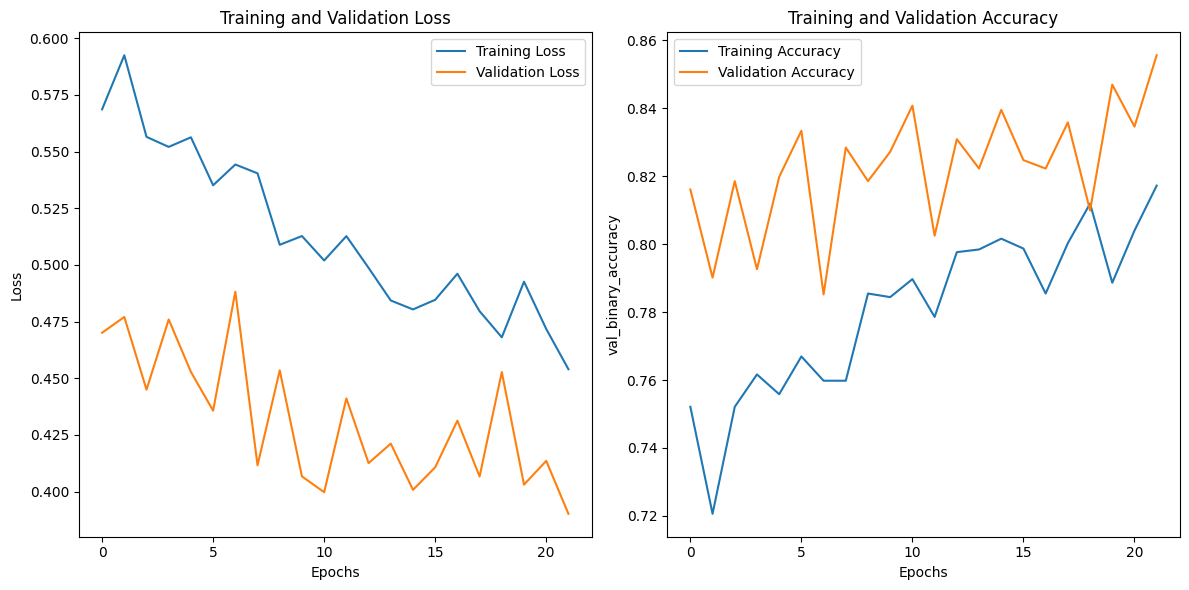

In [70]:
from tensorflow.keras.utils import plot_model

# Visualizar el modelo
plot_model(best_model, to_file="model_structure.png", show_shapes=True, show_layer_names=True)
import matplotlib.pyplot as plt

epochs = range(len(history['binary_accuracy']))

# Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['binary_accuracy'], label='Training Accuracy')
plt.plot(epochs, history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('val_binary_accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

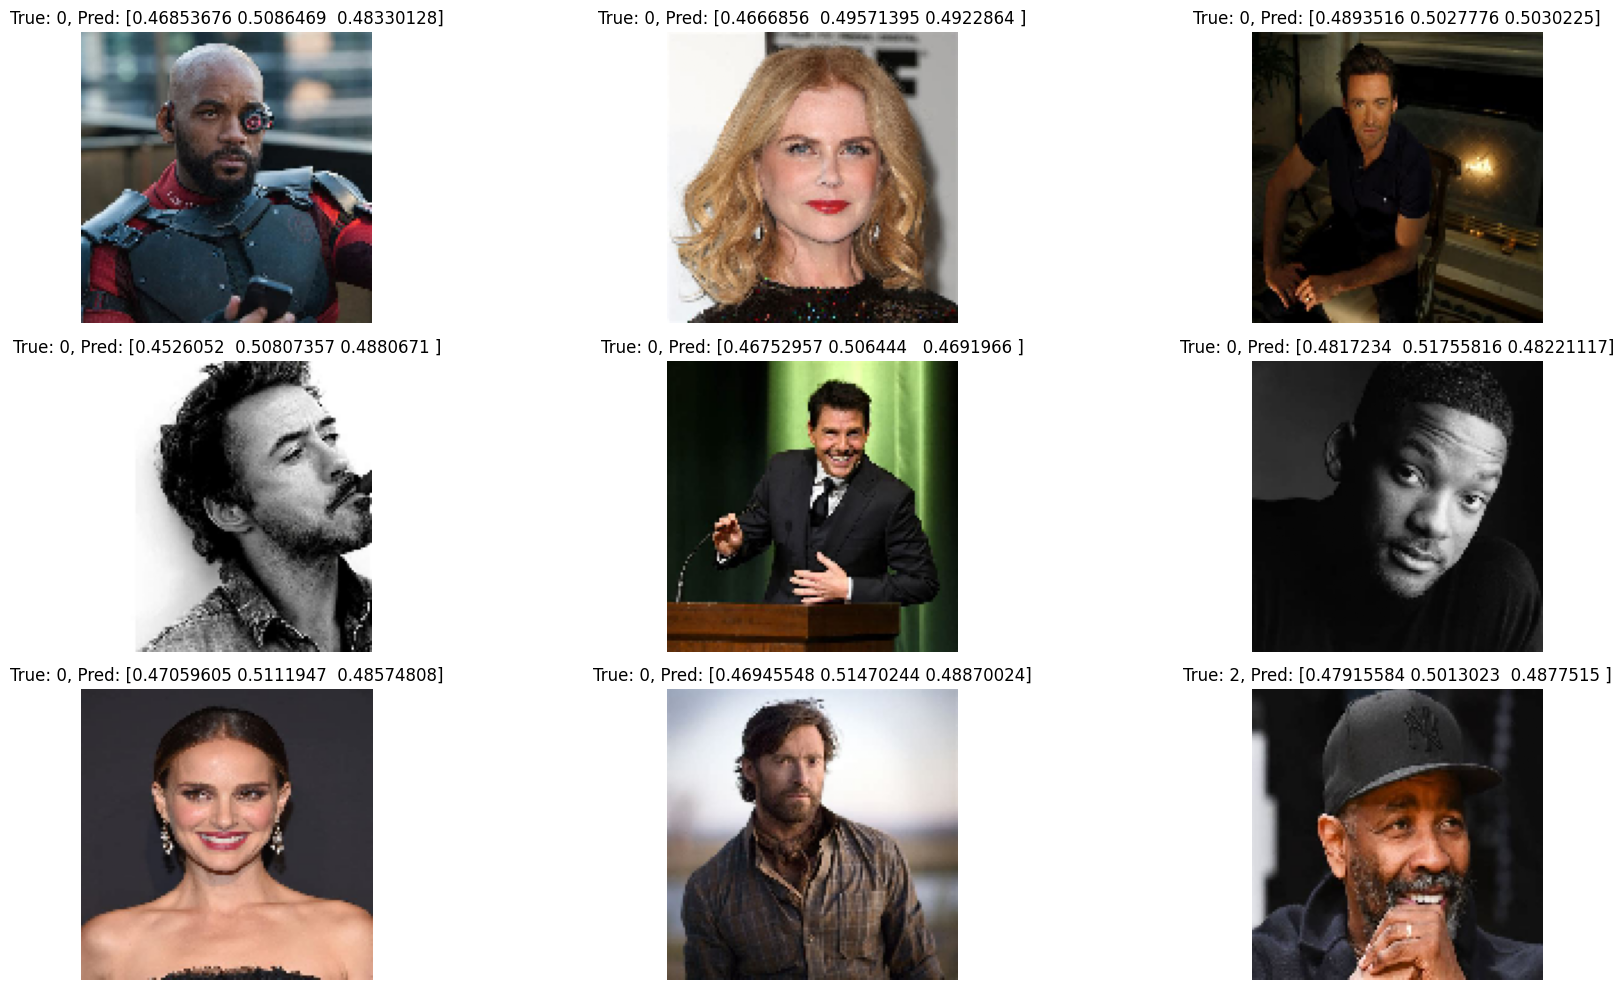

In [77]:
# Mostrar predicciones aleatorias del conjunto de prueba
import random

fig, axes = plt.subplots(3, 3, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    idx = random.randint(0, len(X_test))
    ax.imshow(X_test[idx])
    ax.set_title(f"True: {np.argmax(y_test[idx])}, Pred: {y_pred[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()